In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, [1]))
print('using GPU %s' % ','.join(map(str, [1])))

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from thop import profile, clever_format

import csv
import time
import numpy as np
import json
from datetime import datetime
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 

from option import opt
from loadData import data_pipe
from loadData.dataAugmentation import dataAugmentation
from transformers import get_cosine_schedule_with_warmup

# MD models
from models import S2ENet, FusAtNet, SHNet, heads, MDL
# from models.MS2CANet import pymodel
from models.MS2CANet2 import pymodel
from models.CrossHL import CrossHL
from models.HCTNet import HCTNet
from models.DSHFNet import DSHF
from models.MIViT import MMA
from models import get_model_config

from utils import trainer, tester, focalLoss, tools, visualation

using GPU 1


In [2]:
args = opt.get_args()
# args.dataset_name = "PaviaU"
args.dataset_name = "Houston_2013"

# args.backbone = "MDL_M"
args.backbone = "MDL_L"
# args.backbone = "MDL_E_D"
# args.backbone = "MDL_C"

# args.backbone = "MS2CANet"
args.backbone = "S2ENet"
# args.backbone = "FusAtNet"
# args.backbone = "CrossHL"
# args.backbone = "HCTNet"
# args.backbone = "DSHFNet"
# args.backbone = "MIViT"
# args.backbone = "SHNet"

args.split_type = "disjoint"
get_model_config(args)

print("args.backbone", args.backbone)

args.backbone S2ENet


In [3]:
# data_pipe.set_deterministic(seed = 666)
args.print_data_info = True
args.data_info_start = 1
args.show_gt = False
args.remove_zero_labels = True


if args.backbone in args.SSISO:
    transform = dataAugmentation(args.randomCrop)   # 有些模型加增强，会造成测试精度下降很多
else:
    transform = None


# create dataloader
if args.dataset_name in args.SD:
    args.train_ratio = 0.014
    args.path_data = "/home/icclab/Documents/lqw/DatasetSMD"
    # img1, train_gt, val_gt, test_gt, data_gt, GT = data_pipe.get_data(args)
    img1, img2, train_gt, val_gt, test_gt, data_gt, GT = data_pipe.get_data(args)   # 为了统一
    args.components = img1.shape[2]
    print(img1.shape, train_gt.shape, val_gt.shape, test_gt.shape, data_gt.shape, GT.shape)
elif args.dataset_name in args.MD:
    args.train_ratio = 0.9
    args.path_data = "/home/icclab/Documents/lqw/DatasetMMF"
    img1, img2, train_gt, val_gt, test_gt, data_gt, GT = data_pipe.get_data(args)
    print(img1.shape, img2.shape, train_gt.shape, val_gt.shape, test_gt.shape, data_gt.shape, GT.shape)


if args.backbone in args.MMISO or args.backbone in args.MMIMO:
    print("mutlisacle multimodality")
    # 在这直接输出多尺度的图像
    train_dataset = data_pipe.HyperXMM(img1, data2=img2, gt=train_gt, 
                                    transform=transform, patch_size=args.patch_size, 
                                    remove_zero_labels=args.remove_zero_labels)
    test_dataset = data_pipe.HyperXMM(img1, data2=img2, gt=test_gt, 
                                    transform=None, patch_size=args.patch_size, 
                                    remove_zero_labels=args.remove_zero_labels)
    
    height, wigth, data1_bands = train_dataset.data1.shape
    height, wigth, data2_bands = train_dataset.data2.shape

    # 用于 focalloss
    train_gt_pure = train_gt[train_gt > 0] - 1
    test_gt_pure = test_gt[test_gt > 0] - 1
    loss_weight = focalLoss.loss_weight_calculation(test_gt_pure)
    print("data1", train_dataset.data1.shape, "data2", train_dataset.data2.shape)


elif args.backbone in args.SSISO or args.backbone in args.SMIMO \
    or args.backbone in args.SMISO or args.backbone in args.SMIMO2 \
    or args.backbone in args.SMIMO3:

    print("singlescale multimodality")
    train_dataset = data_pipe.HyperX(img1, data2=img2, gt=train_gt, 
                                    transform=transform, patch_size=args.patch_size, 
                                    remove_zero_labels=args.remove_zero_labels)
    val_dataset = data_pipe.HyperX(img1, data2=img2, gt=val_gt, 
                                    transform=transform, patch_size=args.patch_size, 
                                    remove_zero_labels=args.remove_zero_labels)
    test_dataset = data_pipe.HyperX(img1, data2=img2, gt=test_gt, 
                                    transform=None, patch_size=args.patch_size, 
                                    remove_zero_labels=args.remove_zero_labels)
    
    height, wigth, data1_bands = train_dataset.data1.shape
    height, wigth, data2_bands = train_dataset.data2.shape
    print("data1", train_dataset.data1.shape, "data2", train_dataset.data2.shape)


train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

class_num = np.max(train_gt)
print(class_num, train_gt.shape, len(train_loader.dataset))

pca is used
split_type:  disjoint 
train_ratio:  0.9
print_data_info : ---->
class 1 	 182 	 16 	 1053
class 2 	 171 	 19 	 1064
class 3 	 175 	 17 	 505
class 4 	 172 	 16 	 1056
class 5 	 170 	 16 	 1056
class 6 	 167 	 15 	 143
class 7 	 177 	 19 	 1072
class 8 	 172 	 19 	 1053
class 9 	 174 	 19 	 1059
class 10 	 175 	 16 	 1036
class 11 	 166 	 15 	 1054
class 12 	 174 	 18 	 1041
class 13 	 168 	 16 	 285
class 14 	 167 	 14 	 247
class 15 	 170 	 17 	 473
total     	 2580 	 252 	 12197
(357, 1913, 20) (357, 1913, 1) (357, 1913) (357, 1913) (357, 1913) (357, 1913) (349, 1905)
singlescale multimodality
data1 (357, 1913, 20) data2 (357, 1913, 1)
15 (357, 1913) 2580


In [4]:
if args.backbone in args.MMISO or args.backbone in args.MMIMO:
    for data11, data12, data13, data21, data22, data23, label in train_loader:
        print("x.shape, y.shape", data11.shape, data12.shape, data13.shape)
        print("x.shape, y.shape", data11.dtype, data12.dtype, data13.dtype)

        print("x.shape, y.shape", data21.shape, data22.shape, data23.shape)
        print("x.shape, y.shape", data21.dtype, data22.dtype, data23.dtype)
        break
elif args.backbone in args.SSISO or args.backbone in args.SMISO or args.backbone in args.SMIMO:
    for data11, data12, label in train_loader:
        print("x.shape, y.shape", data11.shape, data12.shape, label.shape)
        print("x.shape, y.shape", data11.dtype, data12.dtype, label.dtype)
        break
elif args.backbone in args.SSSM:
    for x, z in train_loader:
        print("x.shape, y.shape", x.shape, z.shape)
        break

x.shape, y.shape torch.Size([64, 20, 7, 7]) torch.Size([64, 1, 7, 7]) torch.Size([64])
x.shape, y.shape torch.float32 torch.float32 torch.int64


In [5]:
# print((data21[0, 0, :, :].shape))
# print((data22[0, 0, 3:9, 3:9].shape))
# print((data23[0, 0, 6:12, 6:12].shape))
# print(data21.shape)

# # data21[20, 0, :, :], data22[20, 0, 3:9, 3:9], data23[20, 0, 6:12, 6:12]

# path

In [6]:
args.result_dir = os.path.join("/home/icclab/Documents/lqw/Multimodal_Classification/PatchwiseClsFra/result",
                    datetime.now().strftime("%m-%d-%H-%M-") + args.backbone)
print(args.result_dir)

# 加载已有权重路径
# args.result_dir = "/home/liuquanwei/code/DMVL_joint_MNDIS/results_final/08-09-17-05-vit_D8"
if not os.path.exists(args.result_dir):
    os.mkdir(args.result_dir)
with open(args.result_dir + '/args.json', 'w') as fid:
    json.dump(args.__dict__, fid, indent=2)

/home/icclab/Documents/lqw/Multimodal_Classification/PatchwiseClsFra/result/08-02-14-33-S2ENet


# model

In [7]:
criterion = torch.nn.CrossEntropyLoss()
super_head = None


if args.backbone == "MDL_M":
    model = MDL.Middle_fusion_CNN(data1_bands, data2_bands, class_num).to(args.device)
    params = model.parameters()
    print("model: ", "MDL_M")

elif  args.backbone == "MDL_L":
    model = MDL.Late_fusion_CNN(data1_bands, data2_bands, class_num).to(args.device)
    params = model.parameters()
    print("model: ", "MDL_L")

elif args.backbone == "MDL_E_D":
    model = MDL.En_De_fusion_CNN(data1_bands, data2_bands, class_num).to(args.device)
    params = model.parameters()
    print("model: ", "MDL_E_D")

elif  args.backbone == "MDL_C":
    model = MDL.Cross_fusion_CNN(data1_bands, data2_bands, class_num).to(args.device)
    params = model.parameters()
    print("model: ", "MDL_C")


elif args.backbone == "MS2CANet":
    FM = 64
    args.feature_dim = 256
    para_tune = False
    if args.dataset_name == "Houston_2013":
        para_tune = True                # para_tune 这个参数对于 Houston 的提升有两个点！！

    # model = pymodel.pyCNN(data1_bands, data2_bands, classes=class_num, \
    #                       FM=FM, para_tune=para_tune).to(args.device)
    # params = model.parameters()

    model = pymodel.pyCNN(data1_bands, data2_bands, FM=FM, para_tune=para_tune).to(args.device)
    super_head = heads.MS2_head(args.feature_dim, class_num=class_num).to(args.device)
    params = list(super_head.parameters())  + list(model.parameters())

elif args.backbone == 'S2ENet':
    model = S2ENet.S2ENet(data1_bands, data2_bands, class_num, \
                            patch_size=args.patch_size).to(args.device)
    params = model.parameters()

elif args.backbone == "FusAtNet":
    model = FusAtNet.FusAtNet(data1_bands, data2_bands, class_num).to(args.device)
    params = model.parameters()

elif args.backbone == "CrossHL":
    FM = 16
    model = CrossHL.CrossHL_Transformer(FM, data1_bands, data2_bands, class_num, \
                                        args.patch_size).to(args.device)
    params = model.parameters()

elif args.backbone == "HCTNet":
    model = HCTNet(in_channels=1, num_classes=class_num).to(args.device)
    params = model.parameters()

elif args.backbone == "SHNet":
    FM = 64
    # FM = 16
    model = SHNet.SHNet(data1_bands, data2_bands, feature=FM, \
                        num_classes=class_num, factors=args.factors).to(args.device)
    params = model.parameters()

elif args.backbone == "DSHFNet":
    model = DSHF(l1=data1_bands, l2=data2_bands, \
                num_classes=class_num, encoder_embed_dim=64).to(args.device)
    params = model.parameters()

elif args.backbone == "MIViT":
    model = MMA.MMA(l1=data1_bands, l2=data2_bands, patch_size=args.patch_size, \
                num_patches=64, num_classes=class_num,
                encoder_embed_dim=64, decoder_embed_dim=32, en_depth=5, \
                en_heads=4, de_depth=5, de_heads=4, mlp_dim=8, dropout=0.1, \
                emb_dropout=0.1,fusion=args.fusion).to(args.device)
    params = model.parameters()
    
    loss_weight = loss_weight.to(args.device)
    criterion = focalLoss.FocalLoss(loss_weight, gamma=2, alpha=None)

else:
    raise NotImplementedError("No models")
print("backbone: ", args.backbone)

backbone:  S2ENet


In [8]:
# flops, params = profile(net, inputs=(torch.randn(1, 
#                                                 args.components, 
#                                                 args.patch_size, 
#                                                 args.patch_size).cuda(),))
# flops, params = clever_format([flops, params])
# print('# Model Params: {} FLOPs: {}'.format(params, flops))

# # contra_head
# flops, params = profile(contra_head, inputs=(torch.randn(1, args.feature_dim).cuda(),))
# flops, params = clever_format([flops, params])
# print('# Model Params: {} FLOPs: {}'.format(params, flops))

# # super_head
# flops, params = profile(super_head, inputs=(torch.randn(1, args.feature_dim).cuda(),))
# flops, params = clever_format([flops, params])
# print('# Model Params: {} FLOPs: {}'.format(params, flops))

In [9]:
if not args.schedule:
	print("marker")
	optimizer = optim.Adam(params, lr=args.learning_rate)

elif args.backbone == "S2ENet" \
	or args.backbone == "morphFormer":
	print("marker2")
	optimizer = optim.Adam(params, lr=args.learning_rate, weight_decay=args.weight_decay)
	scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

elif args.backbone == "DBCTNet":
	print("marker3")
	optimizer = optim.Adam(params, lr=args.learning_rate, weight_decay=args.weight_decay)
	scheduler = get_cosine_schedule_with_warmup(optimizer, \
				num_warmup_steps = 0.1*args.epochs*len(train_loader), \
				num_training_steps = args.epochs*len(train_loader))

else:
	print("marker4")
	optimizer = optim.Adam(params, lr=args.learning_rate, weight_decay=args.weight_decay)
	scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)


marker2


# 训练前加载权重

In [10]:
# args.resume = os.path.join(args.result_dir, "joint_oa_model.pth")
if args.resume != '':
    checkpoint = torch.load(args.resume)
    model.load_state_dict(checkpoint['base'], strict=False)
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(args.resume))
else:
    epoch_start = 0

# 训练 Train

In [11]:
best_loss = 999
best_acc = 0
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

total_train_time = time.time()

for epoch in range(epoch_start, args.epochs):
    
    if args.backbone in args.SMIMO:
        train_loss, train_accuracy, test_loss, test_accuracy, train_time \
                                        = trainer.train_SMIMO(epoch, model, super_head, \
                                        criterion, train_loader, val_loader, optimizer, args)

    elif args.backbone in args.SMIMO2:
        train_loss, train_accuracy, test_loss, test_accuracy, train_time \
                                        = trainer.train_SMIMO2(epoch, model, criterion, \
                                        train_loader, val_loader, optimizer, args)
        
    elif args.backbone in args.SMIMO3:
        train_loss, train_accuracy, test_loss, test_accuracy, train_time \
                                        = trainer.train_SMIMO3(epoch, model, criterion, \
                                        train_loader, val_loader, optimizer, args)

    elif args.backbone in args.SMISO:
        train_loss, train_accuracy, test_loss, test_accuracy, train_time \
                                        = trainer.train_SMISO(epoch, model, criterion, \
                                        train_loader, val_loader, optimizer, args)
        
    elif args.backbone in args.MMISO:
        train_loss, train_accuracy, test_loss, test_accuracy, train_time \
                                        = trainer.train_MMISO(epoch, model, criterion, \
                                        train_loader, val_loader, optimizer, args)
        
    elif args.backbone in args.MMIMO:
        train_loss, train_accuracy, test_loss, test_accuracy, train_time \
                                        = trainer.train_MMIMO(epoch, model, criterion, \
                                        train_loader, val_loader, optimizer, args)
    
    else:
        raise NotImplementedError("NO this model")
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    if not args.schedule:
        pass
    else:
        scheduler.step()
    
    with open(os.path.join(args.result_dir, "log.csv"), 'a+', encoding='gbk') as f:
        row=[["epoch", epoch, 
            "train loss", train_loss, 
            "test loss", test_loss, 
            "train_accuracy", train_accuracy,
            "test_accuracy", test_accuracy,
            "train_time", train_time,
            '\n']]
        write=csv.writer(f)
        for i in range(len(row)):
            write.writerow(row[i])

    best_loss, best_acc = tools.save_weights(train_loss, test_loss, best_loss, best_acc, \
                                       test_accuracy, epoch, model, super_head, optimizer, args)
        
total_train_time = time.time() - total_train_time


if super_head != None:
    torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "super_head": super_head.state_dict(),
            "optimizer": optimizer.state_dict()}, 
            os.path.join(args.result_dir, "model_last.pth"))
else:
    torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()}, 
            os.path.join(args.result_dir, "model_last.pth"))

Train Epoch: [0/128] TrainLoss: 1.9896 TrainAcc: 59.46 TestLoss: 6.7234 TestAcc: 61.90 TIME: 1.10
Train Epoch: [1/128] TrainLoss: 1.2154 TrainAcc: 85.47 TestLoss: 4.3124 TestAcc: 83.73 TIME: 0.58
Train Epoch: [2/128] TrainLoss: 0.7329 TrainAcc: 95.66 TestLoss: 2.9255 TestAcc: 84.13 TIME: 0.55
Train Epoch: [3/128] TrainLoss: 0.4200 TrainAcc: 97.91 TestLoss: 2.5376 TestAcc: 80.16 TIME: 0.56
Train Epoch: [4/128] TrainLoss: 0.2448 TrainAcc: 98.88 TestLoss: 1.9071 TestAcc: 79.76 TIME: 0.56
Train Epoch: [5/128] TrainLoss: 0.1568 TrainAcc: 98.91 TestLoss: 2.0698 TestAcc: 87.30 TIME: 0.56
Train Epoch: [6/128] TrainLoss: 0.1047 TrainAcc: 99.15 TestLoss: 1.5491 TestAcc: 85.71 TIME: 0.58
Train Epoch: [7/128] TrainLoss: 0.0806 TrainAcc: 99.07 TestLoss: 1.6288 TestAcc: 85.71 TIME: 0.56
Train Epoch: [8/128] TrainLoss: 0.0682 TrainAcc: 99.03 TestLoss: 1.1934 TestAcc: 89.29 TIME: 0.53
Train Epoch: [9/128] TrainLoss: 0.0498 TrainAcc: 99.22 TestLoss: 1.1961 TestAcc: 88.49 TIME: 0.53
Train Epoch: [10/128

# 测试 Test

In [12]:
# args.result_dir = "/home/leo/Multimodal_Classification/MyMultiModal/result/03-25-12-26-MIViT"
args.resume = os.path.join(args.result_dir, "test_loss.pth")
# args.resume = os.path.join(args.result_dir, "test_acc.pth")
if args.resume != '':
    checkpoint = torch.load(args.resume)
    model.load_state_dict(checkpoint['model'], strict=False)
    if super_head != None:
        super_head.load_state_dict(checkpoint['super_head'], strict=False)
    epoch = checkpoint['epoch'] + 1
    print('Loaded from: {} epoch {}'.format(args.resume, epoch))
else:
    epoch_start = 0

tic = time.time()

if args.backbone in args.SSISO:
    test_preds, targets = tester.test_SSISO(model, super_head, criterion, test_loader, args)
if args.backbone in args.SMIMO:
    test_preds, targets = tester.test_SMIMO(model, super_head, criterion, test_loader, args)
if args.backbone in args.SMIMO2:
    test_preds, targets = tester.test_SMIMO2(model, criterion, test_loader, args)
if args.backbone in args.SMIMO3:
    test_preds, targets = tester.test_SMIMO3(model, criterion, test_loader, args)
elif args.backbone in args.SMISO:
    test_preds, targets = tester.test_SMISO(model, criterion, test_loader, args)
elif args.backbone in args.MMISO:
    test_preds, targets = tester.test_MMISO(model, criterion, test_loader, args)
elif args.backbone in args.MMIMO:
    test_preds, targets = tester.test_MMIMO(model, criterion, test_loader, args)
classification, kappa = tester.get_results(test_preds, targets)

test_time = time.time() - tic

with open(os.path.join(args.result_dir, "log_final.csv"), 'a+', encoding='gbk') as f:
    row=[["training",
        "\nepoch", epoch, 
        "\ndata_name = " + str(args.dataset_name),
        "\nbatch_size = " + str(args.batch_size),
        "\npatch_size = " + str(args.patch_size),
        "\nnum_components = " + str(args.components),
        '\n' + classification,
        "\nkappa = \t\t\t" + str(round(kappa, 4)),
        "\ntotal_time = ", round(total_train_time, 2),
        '\ntest time = \t' + str(round(test_time, 2)),
        ]]
    write=csv.writer(f)
    for i in range(len(row)):
        write.writerow(row[i])

Loaded from: /home/icclab/Documents/lqw/Multimodal_Classification/PatchwiseClsFra/result/08-02-14-33-S2ENet/test_loss.pth epoch 100
Accuracy: 10695/12197 (87.69%)



# 绘图

Loaded from: /home/icclab/Documents/lqw/Multimodal_Classification/PatchwiseClsFra/result/08-02-14-33-S2ENet/test_loss.pth epoch 100
pca is used
split_type:  disjoint 
train_ratio:  1
(357, 1913, 20) (357, 1913, 1) (357, 1913) (357, 1913) (357, 1913) (357, 1913) (349, 1905)
single scale multimodality
data1 (357, 1913, 20) data2 (357, 1913, 1)
Accuracy: 13506/664845 (2.03%)



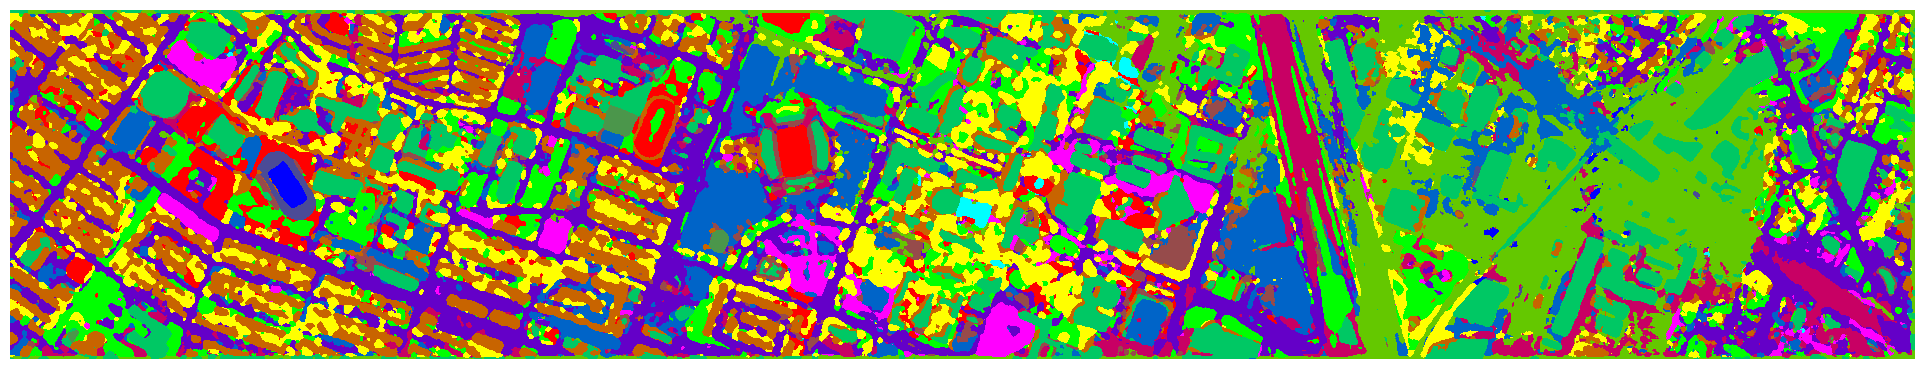

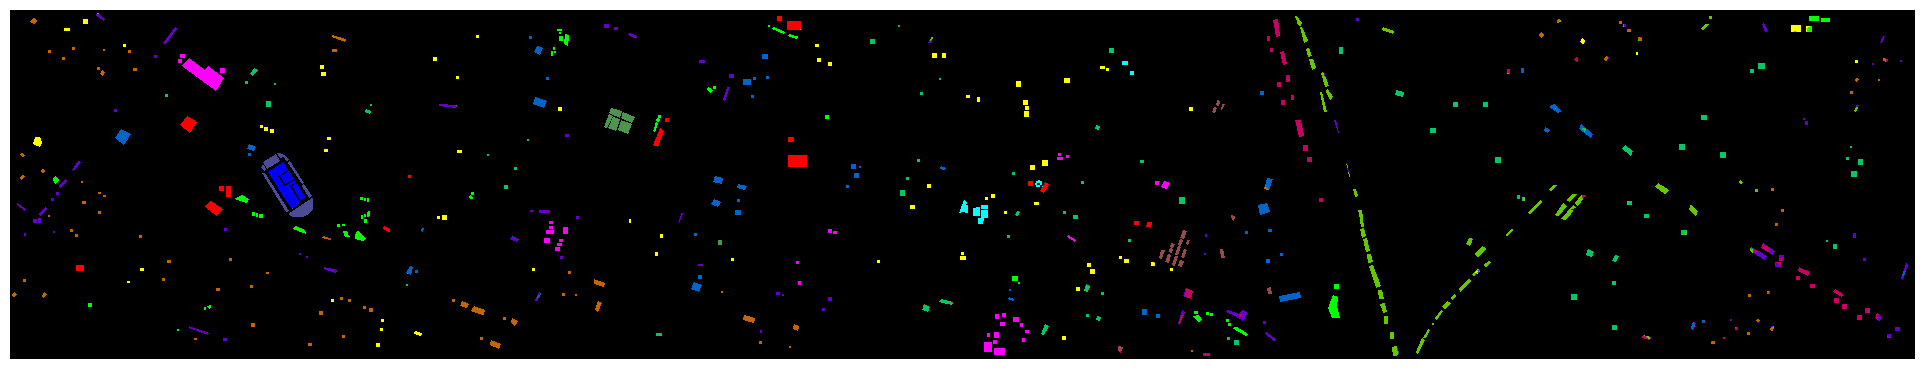

In [13]:
# args.result_dir = "/home/icclab/Documents/lqw/Multimodal_Classification/PatchwiseClsFra/result_Houston13/05-24-16-49-MIViT"
args.resume = os.path.join(args.result_dir, "test_loss.pth")
if args.resume != '':
    checkpoint = torch.load(args.resume)
    # print("checkpoint", checkpoint.keys())
    model.load_state_dict(checkpoint['model'], strict=False)
    if super_head != None:
        super_head.load_state_dict(checkpoint['super_head'], strict=False)
    epoch = checkpoint['epoch'] + 1
    print('Loaded from: {} epoch {}'.format(args.resume, epoch))
else:
    epoch_start = 0


if args.backbone in args.SSISO:
    print("args.randomCrop", args.randomCrop)
    transform = dataAugmentation(args.randomCrop)   # 有些模型加增强，会造成测试精度下降很多
else:
    transform = None

args.print_data_info = False
args.data_info_start = 1
args.show_gt = False
args.remove_zero_labels = False

# create dataloader
if args.dataset_name in args.SD:
    args.train_ratio = 1
    args.path_data = "/home/icclab/Documents/lqw/DatasetSMD"
    # img1, train_gt, val_gt, test_gt, data_gt, GT = data_pipe.get_data(args)
    img1, img2, train_gt, val_gt, test_gt, data_gt, GT = data_pipe.get_data(args)   # 为了统一
    args.components = img1.shape[2]
    print(img1.shape, img2.shape, train_gt.shape, val_gt.shape, test_gt.shape, data_gt.shape, GT.shape)
elif args.dataset_name in args.MD:
    args.train_ratio = 1
    args.path_data = "/home/icclab/Documents/lqw/DatasetMMF"
    img1, img2, train_gt, val_gt, test_gt, data_gt, GT = data_pipe.get_data(args)
    print(img1.shape, img2.shape, train_gt.shape, val_gt.shape, test_gt.shape, data_gt.shape, GT.shape)


if args.backbone in args.MMISO or args.backbone in args.MMIMO:
    print("mutlisacle multimodality")
    data_dataset = data_pipe.HyperXMM(img1, data2=img2, gt=data_gt, 
                                    transform=None, patch_size=args.patch_size, 
                                    remove_zero_labels=args.remove_zero_labels)
    print("data1", data_dataset.data1.shape, "data2", data_dataset.data2.shape)


elif args.backbone in args.SSISO or args.backbone in args.SMIMO \
    or args.backbone in args.SMISO or args.backbone in args.SMIMO2 \
    or args.backbone in args.SMIMO3:

    print("single scale multimodality")
    data_dataset = data_pipe.HyperX(img1, data2=img2, gt=data_gt, 
                                    transform=None, patch_size=args.patch_size, 
                                    remove_zero_labels=args.remove_zero_labels)
    print("data1", data_dataset.data1.shape, "data2", data_dataset.data2.shape)


data_loader = DataLoader(data_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False)


if args.backbone in args.SSISO:
    visualation.visualation_SSISO(model, super_head, data_loader, args, groundTruth=GT, visulation=True)
if args.backbone in args.SMIMO:
    visualation.visualation_SMIMO(model, super_head, data_loader, args, groundTruth=GT, visulation=True)
if args.backbone in args.SMIMO2:
    visualation.visualation_SMIMO2(model, data_loader, args, groundTruth=GT, visulation=True)
if args.backbone in args.SMIMO3:
    visualation.visualation_SMIMO3(model, data_loader, args, groundTruth=GT, visulation=True)
elif args.backbone in args.SMISO:
    visualation.visualation_SMISO(model, data_loader, args, groundTruth=GT, visulation=True)
elif args.backbone in args.MMISO:
    visualation.visualation_MMISO(model, data_loader, args, groundTruth=GT, visulation=True)
elif args.backbone in args.MMIMO:
    visualation.visualation_MMIMO(model, data_loader, args, groundTruth=GT, visulation=True)

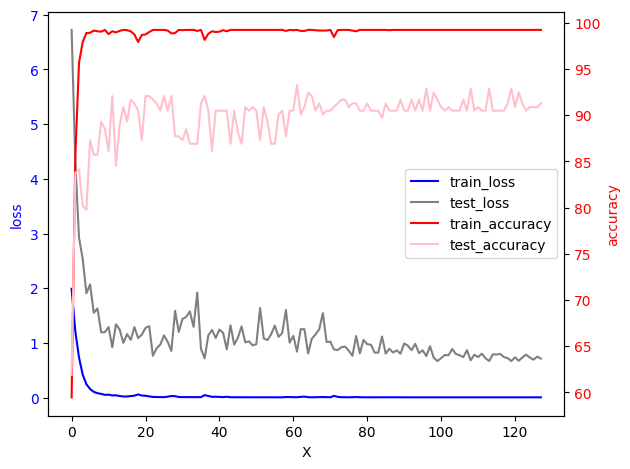

In [14]:
args.plot_loss_curve = True
if args.plot_loss_curve:
    # fig = plt.figure()
    fig, ax1 = plt.subplots()

    # 绘制第一个数据，使用左侧y轴
    ax1.plot(range(args.epochs), train_losses, 'blue', label="train_loss")
    ax1.plot(range(args.epochs), test_losses, 'gray', label="test_loss")
    ax1.set_xlabel('X')
    ax1.set_ylabel('loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # 创建第二个坐标轴，共享x轴但y轴在右侧
    ax2 = ax1.twinx()
    ax2.plot(range(args.epochs), train_accuracies, 'red', label="train_accuracy")
    ax2.plot(range(args.epochs), test_accuracies, 'pink', label="test_accuracy")
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')


    fig.tight_layout()  # 自动调整布局以避免重叠

    # # 获取两个坐标轴上的线条和标签
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=5)
    # plt.legend(['train_losses', 'train_accuracies', 'test_accuracies'], loc='upper right')
    # plt.xlabel('number of training examples seen')
    # plt.ylabel('Accuracy')
    plt.savefig(os.path.join(args.result_dir, "learning_curve.png"), dpi=200)

# TSNE

In [15]:
# with torch.no_grad():
#     for idx_o, (data, _, target) in enumerate(test_loader):
#         target = target - 1
#         data = data.to(args.device)
        
#         output = super_head(net(data))
#         target = target.to(args.device)

#         for idx, _ in enumerate(output.cpu().numpy()):
#             # print(output.cpu().numpy().shape)
#             if idx == 0 and idx_o == 0:
#                 list_output = output.cpu().numpy()[idx]
#                 list_target = target.cpu().numpy()[idx]
#             # print(list_output.shape, list_target.shape)

#             if idx < 100:
#                 list_output = np.vstack((list_output, output.cpu().numpy()[idx]))
#                 list_target = np.append(list_target, target.cpu().numpy()[idx])

In [16]:
# tsne = TSNE()

# out = tsne.fit_transform(list_output)
# fig, ax = plt.subplots()
# ax.set_axis_off()
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# # fig.set_size_inches(label.shape[1] * scale / dpi, label.shape[0] * scale / dpi)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

# label = ["Broccoli-weeds-1","Broccoli-weeds-2","Fallow","Fallow-rough-plow",
#          "Fallow-smooth","Stubble","Celery","Grapes-untrained",
#          "Soil-senesced-develop","Corn-weeds","Lettuce-4wk","Lettuce-5wk",
#          "Lettuce-6wk","Lettuce-7wk","Vinyard-untrained",
#          "Vinyard-vertical-trellis"]
# for i in range(class_num):
#     indices = list_target  == i
#     x, y = out[indices].T
#     # plt.scatter(x, y, s=5, label=label[i])
#     plt.scatter(x, y, s=5, label=str(i+1))
# plt.legend(loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0., fontsize=12)
# plt.savefig(args.result_dir  + '/tsneFull' + '.png', dpi=400, bbox_inches="tight")